In [8]:
%load_ext autoreload
%autoreload 2

import fnmatch
import os
import random
import shutil
import string
import time
from abc import abstractmethod
from collections import defaultdict
from time import sleep

import numpy as np
import monai
from monai.transforms import AddChannel, Compose, Resize, ScaleIntensity, ToTensor
from torch.utils.data import DataLoader, Dataset
from datasets.numpydatasets import Numpy2dDataSet, Numpy3dDataSet
from datasets.cyclegan import CycleGANDataset
import torchvision.transforms as transforms


def get_transforms_2d(target_size=128):
    """Returns a Transform which resizes 2D samples (1xHxW) to a target_size (1 x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """

    transforms = Compose([Resize((target_size, target_size)), ToTensor()])
    return transforms


def get_transforms_3d(target_size=128):
    """Returns a Transform which resizes 3D samples (1xZxYxX) to a target_size (1 x target_size x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """
    transforms = Compose([Resize((target_size, target_size, target_size)), ToTensor()])
    return transforms


def get_numpy2d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=512,
    file_pattern="*data.npy",
    do_reshuffle=True,
    slice_offset=0,
    caching=True,
):
    """Returns a Pytorch data loader which loads a Numpy2dDataSet, i.e. 2D slices from a dir of 3D Numpy arrays.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
        slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
        caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                    so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy2dDataSet
    """

    transforms = get_transforms_2d(target_size=target_size)

    data_set = Numpy2dDataSet(
        base_dir=base_dir,
        mode=mode,
        n_items=n_items,
        file_pattern=file_pattern,
        slice_offset=slice_offset,
        caching=caching,
        transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader


def get_numpy3d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=128,
    file_pattern="*data.npy",
    do_reshuffle=False,
):
    """Returns a Pytorch data loader which loads a Numpy3dDataSet, i.e. 3D Numpy arrays from a directory.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy3dDataSet
    """

    transforms = get_transforms_3d(target_size=target_size)

    data_set = Numpy3dDataSet(
        base_dir=base_dir, mode=mode, n_items=n_items, file_pattern=file_pattern, transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        #shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
ds = Numpy3dDataSet("/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/label_checking/",file_pattern="*.jpeg")

In [31]:
print(ds[0])
# npee = np.array(ds[24])
# x = np.moveaxis(npee, 0,-1)
# #x.shape

# from matplotlib import pyplot as plt
# plt.imshow(x, interpolation='nearest')
# plt.show()

/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/label_checking/crossmoda2021_ldn_100_Label_41.jpeg


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [84]:
from PIL import Image
# Open the image form working directory
img = '/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/label_rgb/crossmoda2021_ldn_100_Label_43.jpeg'
# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot
# load image as pixel array
image = image.imread(img)
import torch
torch.set_printoptions(profile="full")
print(torch.tensor(image[image>0]))


# display the array of pixels as an image
# pyplot.imshow(image)
# pyplot.show()
# import torch
# etc = torch.tensor(image)

tensor([ 68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  83,
         68,  83,  68,  83,  68,  83,  68,  83,  68,  83,  68,  

In [9]:

ds = CycleGANDataset('/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/',is_train=True,transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.CenterCrop((224,224)),transforms.ToTensor()])) # transforms.Normalize(0.0085,0.2753)
val_ds = CycleGANDataset('/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/',is_train=False,transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.CenterCrop((224,224)),transforms.ToTensor()])) # transforms.Normalize(0.0085,0.2753)

In [10]:
val_ds[5]['image'].shape, val_ds[5]['label'].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [5]:
import numpy as np
y = np.asarray('50,100,150')
4 > y


TypeError: '>' not supported between instances of 'int' and 'numpy.ndarray'

In [4]:
from uvcgan.config import Args
import torch
from uvcgan.models.generator import construct_generator
from uvcgan.torch.funcs       import get_torch_device_smart, seed_everything
from uvcgan.cgan.cyclegan           import CycleGANModel
from uvcgan.cgan import construct_model
device = get_torch_device_smart()
args   = Args.load('uvcgan/outdir/selfie2anime/model_d(cyclegan)_m(cyclegan)_d(basic)_g(vit-unet)_cyclegan_vit-unet-12-none-lsgan-paper-cycle_high-256/')
config = args.config
# model = construct_generator(
#     config.generator, config.image_shape, device
# )

model  = construct_model(
        args.savedir, args.config, is_train = False, device = device
    )
print(model.models.gen_ab.net.layer_input[0].weight)



1 == 48


/dss/dsshome1/lxc09/ra49tad2/vit/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


1 == 48
Parameter containing:
tensor([[[[-1.5721e-02, -3.0091e-03, -1.7461e-02],
          [-3.0856e-02, -4.9800e-04, -2.1929e-02],
          [-1.4646e-02,  5.0628e-02,  6.7221e-03]]],


        [[[ 2.6425e-02, -1.2848e-02,  1.7893e-02],
          [-1.6994e-02,  1.8155e-03, -4.6979e-02],
          [ 1.5336e-02, -2.0141e-02, -2.1751e-03]]],


        [[[-5.5185e-03,  1.5113e-02,  1.1808e-02],
          [ 2.2482e-02, -9.8246e-03,  3.6942e-03],
          [-2.5473e-02, -1.5016e-03, -2.1260e-02]]],


        [[[ 9.7908e-03, -1.9463e-04,  9.0913e-03],
          [-5.7353e-03,  1.7663e-02,  9.8290e-04],
          [ 2.8973e-02,  5.6216e-03,  7.0316e-03]]],


        [[[-2.5465e-02, -1.7860e-02, -1.4067e-02],
          [-4.4945e-03,  1.0268e-02, -2.8603e-02],
          [ 5.0799e-02,  2.5225e-02,  1.5697e-02]]],


        [[[ 2.1550e-02,  1.6877e-02, -4.1670e-02],
          [ 3.2006e-02,  5.1438e-04, -3.0358e-02],
          [ 2.4429e-02,  8.0780e-03, -1.7884e-02]]],


        [[[-9.2031e-03,  3.0

In [6]:
dl = DataLoader(ds, batch_size=1,shuffle=False)
val_dl = DataLoader(val_ds, batch_size=110,shuffle=False)

In [7]:
gen = iter(dl)
ex = next(gen)
img = ex['image']
img.shape



torch.Size([1, 1, 224, 224])

In [5]:
import re
base = '/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/semantic_trainA'
for fname in os.listdir(base):
    fullpath = os.path.join(base, fname)
    pattern = re.compile("^([A-Z][0-9]+)+$")
    if pattern.match(fullpath):
        print(fullpath)

            # if not os.path.isfile(fullpath):
            #     continue
            # if labels == False:
            #     ext = os.path.splitext(fname)[1]
            #     if ext not in extensions:
            #         continue

            # result.append(fullpath)

In [47]:
#!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-_8nbo_v0
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-_8nbo_v0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 376 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 6.1 MB/s  eta 0:00:01
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=97937 sha256=4d5db8a2f9d4981528d8db6c9b146e2e79d79f2e90ba89a60ed24e04c5ef6192
  Stored in directory: /tmp/pip-ephem-wheel-cache-lrprgpxt/wheels/5b/bd/df/041378eb4d7881115c6dcdf2ca35ddcb188441321e8a887618
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=e9f2d4abb664ca76a239e755c07ca91ba588b6b3c3a773d1bd204449f35b7c5a
  Stored in directory: /dss/dsshome1/lxc09

In [50]:
from datasets.segmentation import PetModel
import pytorch_lightning as pl
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /dss/dsshome1/lxc09/ra49tad2/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 117MB/s] 


In [61]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloader=dl, 
    val_dataloader=val_dl,
)

MisconfigurationException: You requested GPUs: [0]
 But your machine only has: []

Load checkpoint at epoch 200
torch.Size([1, 1, 224, 224])


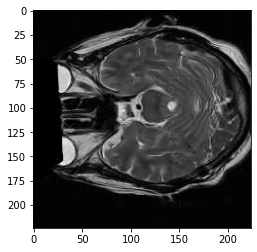

In [8]:
#model = CycleGANModel(**config.model_args)
# ckpt = torch.load(os.path.join('uvcgan/outdir/selfie2anime/model_d(cyclegan)_m(cyclegan)_d(basic)_g(vit-unet)_cyclegan_vit-unet-12-none-lsgan-paper-cycle_high-256/opt_gen.pth'),map_location=torch.device('cpu'))
# state_dict = ckpt

epoch = -1

if epoch == -1:
    epoch = max(model.find_last_checkpoint_epoch(), 0)

print("Load checkpoint at epoch %s" % epoch)

seed_everything(args.config.seed)
model.load(epoch)

gen_ab = model.models.gen_ab
gen_ab.eval()
plot_it_somehow = gen_ab(img).detach().numpy()


plot_it_somehow = plot_it_somehow.squeeze()



import matplotlib.pyplot as plt

plt.imshow(plot_it_somehow, cmap='gray')
plt.show()



# if torch.cuda.is_available():
#     if torch.cuda.device_count() > 1:
#         model = torch.nn.DataParallel(model)
#     else:
#         new_state_dict = {}
#         for k, v in state_dict.items():
#             k = k.replace("module.", "")
#             new_state_dict[k] = v
#         state_dict = new_state_dict
#     model = model.cuda()
# model.load_state_dict(state_dict, strict=True)

In [11]:
ds[10]['image'].shape , ds[10]['label'].shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [13]:
dl = DataLoader(ds, batch_size=1)


In [17]:
import torch
ex = next(iter(dl))
img = ex['label']
torch.set_printoptions(profile="full")
torch.tensor(img.shape)

tensor([  1,   1, 224, 224])

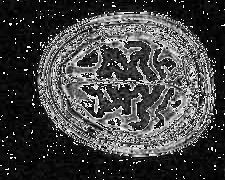

In [6]:
import PIL
PIL.Image.fromarray((img * 255).astype(np.uint8))

In [123]:
mean = 0.0
meansq = 0.0
count = 0
from functools import reduce
for index, data in enumerate(dl):
    #mean= reduce((lambda x, y: x + y), data)
    mean = data.sum()
    #inter = reduce((lambda x, y: x**2 + y), data)
    meansq = meansq + (data**2).sum()
    count += np.prod(data.shape)

In [124]:
total_mean = mean/count
total_var = (meansq/count) - (total_mean**2)
total_std = torch.sqrt(total_var)

In [125]:
total_mean, total_var, total_std

(tensor(0.0081), tensor(0.0758), tensor(0.2753))

In [2]:
import torch
pred = torch.tensor([[0.85, 0.05, 0.05, 0.05],
                            [0.05, 0.85, 0.05, 0.05],
                             [0.05, 0.05, 0.85, 0.05],
                           [0.05, 0.05, 0.05, 0.85]])

/dss/dsshome1/lxc09/ra49tad2/vit/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [85]:
%load_ext autoreload
%autoreload 2

from datasets.cyclegan import CycleGANDataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import SimpleITK as sitk
import os
from datasets.cyclegan import CycleGANDataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from models.unet import UNet
import torch
from preprocessing import nifti_to_2d_slices
# input_dir = '/input/'
# path_img = os.path.join(input_dir,'{}_hrT2.nii.gz')
# path_pred = '/output/{}_Label.nii.gz'

# list_case = [k.split('_hrT2')[0] for k in os.listdir(input_dir)]

data_root= "/dss/dsshome1/lxc09/ra49tad2/data/crossmoda2022_training/"

input_dir = r"crossmoda2022_subset_validation"
output_dir = r"val_subset"
full_input_dir =  os.path.join(data_root, input_dir)
full_output_dir = os.path.join(data_root, output_dir)
axis = 2
do_filter = False
resize = 256
os.makedirs(full_output_dir, exist_ok=True)
complete_input_folder = sorted(os.listdir(full_input_dir))
data_info = nifti_to_2d_slices(full_input_dir, full_output_dir, axis, do_filter, resize,folder=complete_input_folder,type="hrT2")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


In [87]:
opt = {}
opt["checkpoint"] = 'unet_dice0.3378_save1660335644.pt'
opt['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
test_ds = CycleGANDataset(data_root,is_test=True,transform = transforms.Compose([transforms.CenterCrop((174,174)),transforms.Grayscale(num_output_channels=1),transforms.ToTensor()])) # transforms.Normalize(0.0085,0.2753)
model = UNet(n_channels=1, n_classes=3, bilinear=False)
model.load_state_dict(torch.load('./state_dict/{:s}'.format(opt['checkpoint']), map_location=opt['device']))
model = torch.nn.DataParallel(model) 
model = model.to(opt['device'])
model.eval()
print('checkpoint {:s} has been loaded'.format(opt['checkpoint']))
batch_mat = []
counter = 0


checkpoint unet_dice0.3378_save1660335644.pt has been loaded


In [84]:
test_ds[3]

# def collate_data(batch):
#     print("fun")
#     return batch
dl = DataLoader(test_ds, batch_size=2,shuffle=False)
next(iter(dl))

StopIteration: 

In [73]:
single_img = []
counter = 0
for idx, data in enumerate(test_ds):
    inputs, index, fname, dim = data['image'].float(), data['label'], data['file_name'], data['dim']
    counter += 1
    predict = self.model(inputs)
    single_img.append(predict)
    print(f"run model on {fname}-{dim}")
    #print(idx % dim == dim - 1)
    if(counter == dim):
        counter = 0
        single_img = []
        print("Do the compile")
    # index, inputs = sample_batched['image'], sample_batched[label_str].to(self.opt.device)
   

run model on crossmoda2021_ldn_211_hrT2_0.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_1.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_2.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_3.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_4.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_5.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_6.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_7.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_8.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_9.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_10.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_11.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_12.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_13.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_14.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_15.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_16.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_17.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_18.jpeg-80
run model on crossmoda2021_ldn_211_hrT2_1